<h1 style="color:Orange"> Tanzania Tourism Predictions</h1>

The objective of this task is to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania.

### Setting up my Environment and Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df=pd.read_csv('tanzania_train.csv')
test=pd.read_csv('tanzania_test.csv')

### EDA

In [3]:
df.head(5)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


In [4]:
df.describe(percentiles=[0.05,0.95]).T


,count,mean,std,min,5%,50%,95%,max
total_female,4806.0,9.267582e-01,1.288242e+00,0.0,0.0,1.0,3.0,49.0
total_male,4804.0,1.009575e+00,1.138865e+00,0.0,0.0,1.0,2.0,44.0
night_mainland,4809.0,8.488043e+00,1.042762e+01,0.0,0.0,6.0,26.0,145.0
night_zanzibar,4809.0,2.304429e+00,4.227080e+00,0.0,0.0,0.0,10.0,61.0
total_cost,4809.0,8.114389e+06,1.222490e+07,49000.0,140000.0,3397875.0,33481500.0,99532875.0


The max of the data is very far away from the 95% . It is a sign of outliers and to improve our model, we need to handle them. I'll use the capping technique

In [5]:
# Lets try capping the outliers before coming back to check which columns have such values
import warnings
warnings.filterwarnings("ignore")

df['total_female'].loc[df['total_female'] > 3.000000]  = 4.000000
df['total_male'].loc[df['total_male'] > 2.000000]  = 3.000000
df['night_mainland'].loc[df['night_mainland'] > 28.000000]  = 30.000000
df['night_zanzibar'].loc[df['night_zanzibar'] > 10.000000]  = 11.000000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [7]:
variables=pd.read_csv('TVariableDefinitions.csv')

In [8]:
variables

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


# EDA

Top countries where tourists come from

In [9]:
df['country'].value_counts().head(10)

UNITED STATES OF AMERICA    695
UNITED KINGDOM              533
ITALY                       393
FRANCE                      280
ZIMBABWE                    274
SOUTH AFRICA                235
KENYA                       235
GERMANY                     223
ZAMBIA                      191
AUSTRALIA                   186
Name: country, dtype: int64

Who accompanies the tourist the most

In [10]:
df['travel_with'].value_counts()

Alone                  1265
Spouse                 1005
Friends/Relatives       895
Spouse and Children     368
Children                162
Name: travel_with, dtype: int64

Gender distribution

<AxesSubplot:xlabel='total_female', ylabel='count'>

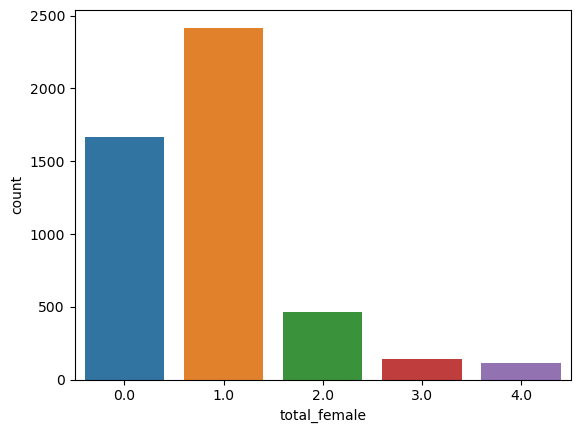

In [11]:
sns.countplot(x='total_female',data=df)

<AxesSubplot:xlabel='total_male', ylabel='count'>

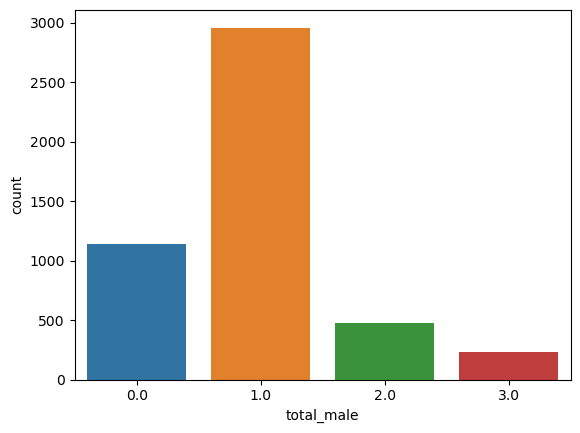

In [12]:
sns.countplot(x='total_male',data=df)

In [13]:
df['total_male'].sum()
#more males than females

4601.0

In [14]:
df['total_female'].sum()

4224.0

Understanding tourists purpose of visit-
most tourists come for leisure

In [15]:
df['purpose'].value_counts()

Leisure and Holidays              2840
Business                           671
Visiting Friends and Relatives     633
Meetings and Conference            312
Volunteering                       138
Other                              128
Scientific and Academic             87
Name: purpose, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Leisure and Holidays'),
  Text(1, 0, 'Visiting Friends and Relatives'),
  Text(2, 0, 'Business'),
  Text(3, 0, 'Meetings and Conference'),
  Text(4, 0, 'Volunteering'),
  Text(5, 0, 'Scientific and Academic'),
  Text(6, 0, 'Other')])

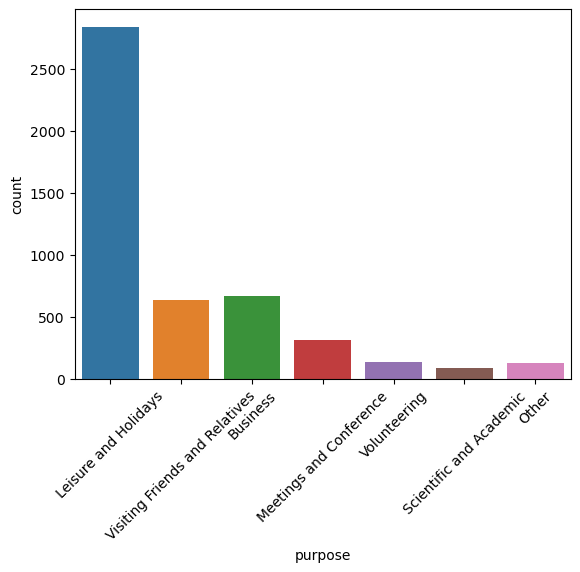

In [16]:
sns.countplot(x='purpose',data=df)
plt.xticks(rotation=45)

Main activity is wildlife tourism,Beach tourism

Wildlife tourism            2259
Beach tourism               1025
Hunting tourism              457
Conference tourism           367
Cultural tourism             359
Mountain climbing            234
business                      58
Bird watching                 37
Diving and Sport Fishing      13
Name: main_activity, dtype: int64


Text(0.5, 0, 'main_activity')

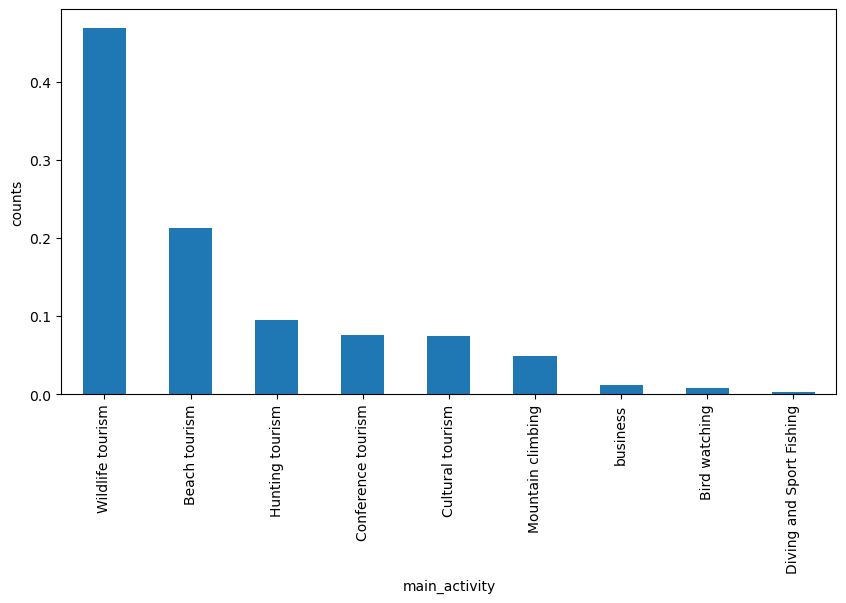

In [17]:
print(df['main_activity'].value_counts())
plt.figure(figsize=(10,5))
df['main_activity'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('main_activity')

<function matplotlib.pyplot.show(close=None, block=None)>

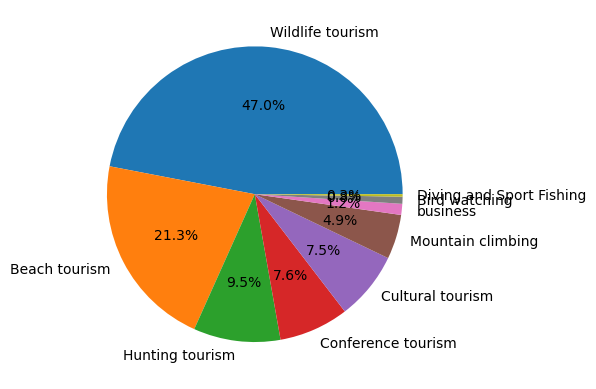

In [18]:
category_counts=df['main_activity'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.show


How did they hear about places they are visiting.
this info can be used by the marketing team to know which channel is bringong more tourists

In [19]:
df['info_source'].value_counts()

Travel, agent, tour operator      1913
Friends, relatives                1635
others                             490
Newspaper, magazines,brochures     359
Radio, TV, Web                     249
Trade fair                          77
Tanzania Mission Abroad             68
inflight magazines                  18
Name: info_source, dtype: int64

In [20]:
df['most_impressing'].value_counts()

Friendly People                         1541
 Wildlife                               1038
No comments                              743
Wonderful Country, Landscape, Nature     507
Good service                             365
Excellent Experience                     271
Satisfies and Hope Come Back              31
Name: most_impressing, dtype: int64

Travel, agent, tour operator      1913
Friends, relatives                1635
others                             490
Newspaper, magazines,brochures     359
Radio, TV, Web                     249
Trade fair                          77
Tanzania Mission Abroad             68
inflight magazines                  18
Name: info_source, dtype: int64


Text(0.5, 0, 'info_source')

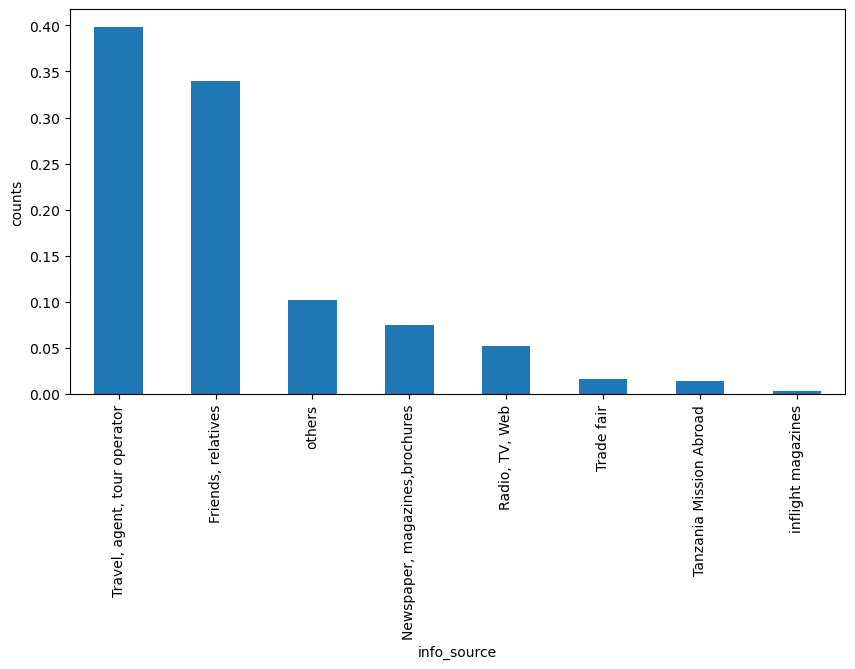

In [21]:
print(df['info_source'].value_counts())
plt.figure(figsize=(10,5))
df['info_source'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('info_source')

Independent     2570
Package Tour    2239
Name: tour_arrangement, dtype: int64


Text(0.5, 0, 'tour_arrangement')

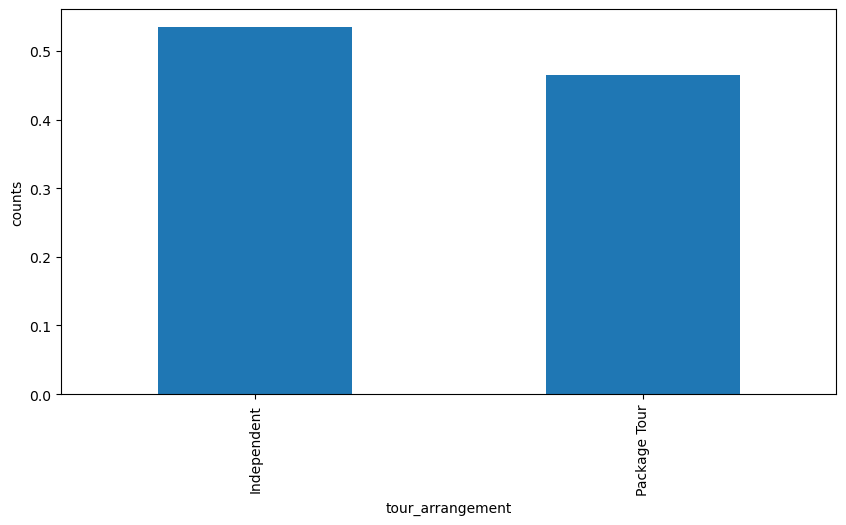

In [22]:
print(df['tour_arrangement'].value_counts())
plt.figure(figsize=(10,5))
df['tour_arrangement'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('tour_arrangement')

No     3357
Yes    1452
Name: package_transport_int, dtype: int64


Text(0.5, 0, 'package_transport_int')

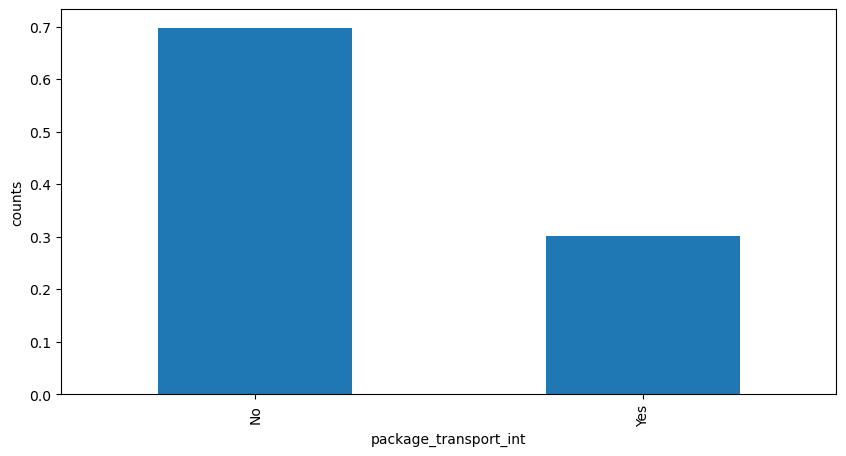

In [23]:
print(df['package_transport_int'].value_counts())
plt.figure(figsize=(10,5))
df['package_transport_int'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_int')

No     2919
Yes    1890
Name: package_transport_tz, dtype: int64


Text(0.5, 0, 'package_transport_tz')

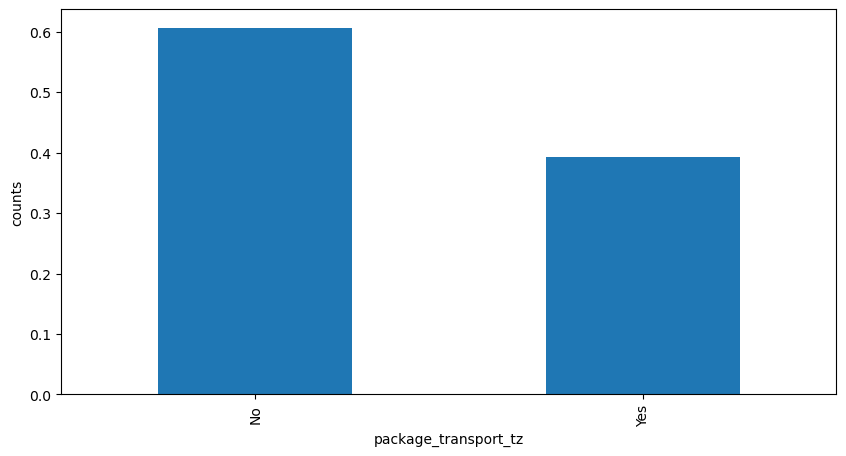

In [24]:
print(df['package_transport_tz'].value_counts())
plt.figure(figsize=(10,5))
df['package_transport_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_tz')

No     3319
Yes    1490
Name: package_sightseeing, dtype: int64


Text(0.5, 0, 'package_sightseeing')

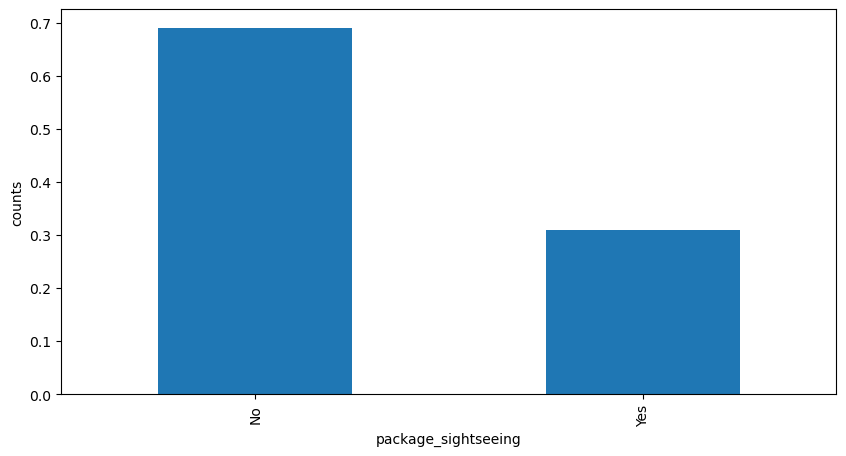

In [25]:
print(df['package_sightseeing'].value_counts())
plt.figure(figsize=(10,5))
df['package_sightseeing'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_sightseeing')

No     3259
Yes    1550
Name: package_guided_tour, dtype: int64


Text(0.5, 0, 'package_guided_tour')

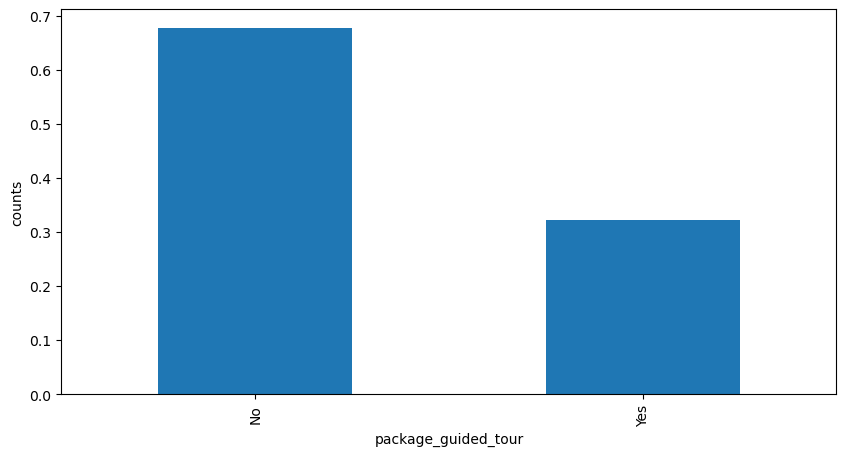

In [26]:
print(df['package_guided_tour'].value_counts())
plt.figure(figsize=(10,5))
df['package_guided_tour'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_guided_tour')

No     4079
Yes     730
Name: package_insurance, dtype: int64


Text(0.5, 0, 'package_insurance')

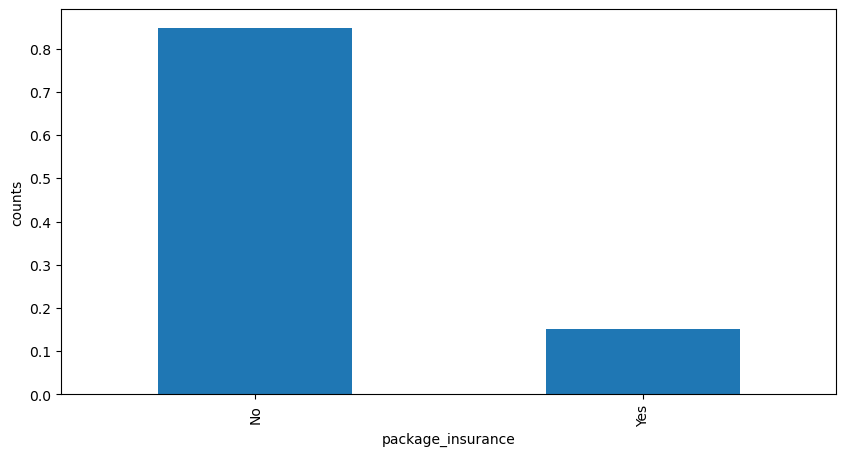

In [27]:
print(df['package_insurance'].value_counts())
plt.figure(figsize=(10,5))
df['package_insurance'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_insurance')

Cash                 4172
Credit Card           622
Other                   8
Travellers Cheque       7
Name: payment_mode, dtype: int64


Text(0.5, 0, 'payment_mode')

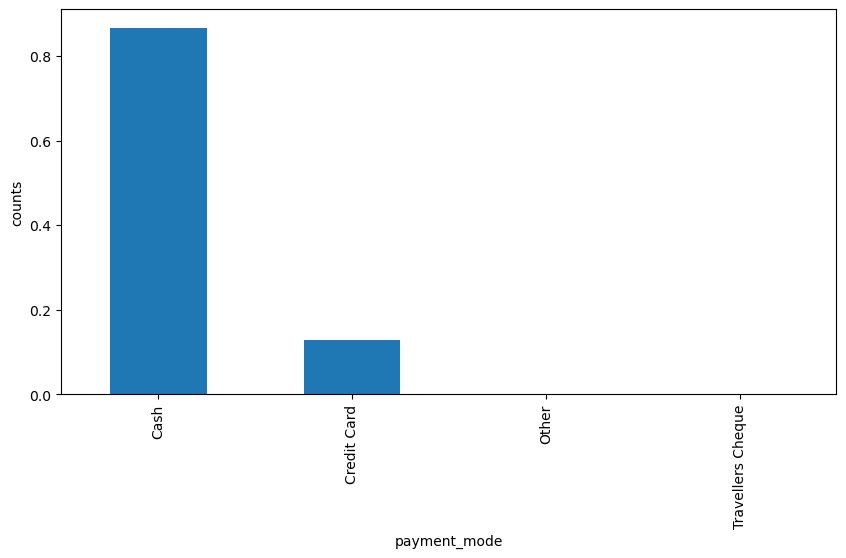

In [28]:
print(df['payment_mode'].value_counts())
plt.figure(figsize=(10,5))
df['payment_mode'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('payment_mode')

Yes    3243
No     1566
Name: first_trip_tz, dtype: int64


Text(0.5, 0, 'first_trip_tz')

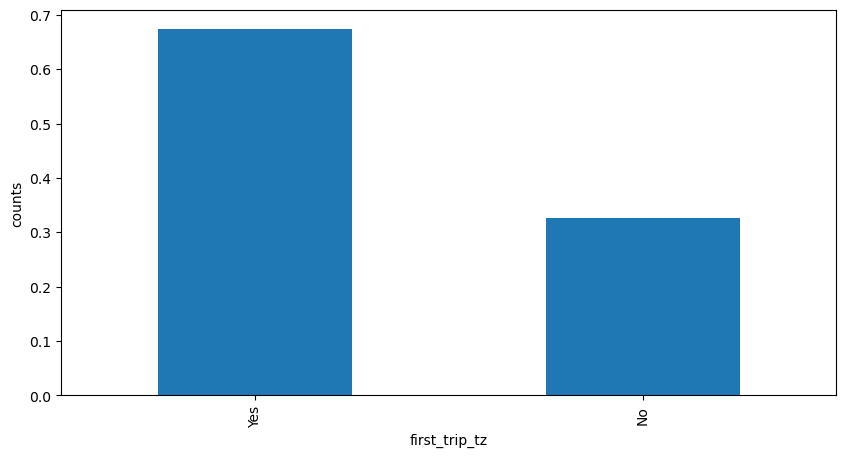

In [29]:
print(df['first_trip_tz'].value_counts())
plt.figure(figsize=(10,5))
df['first_trip_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('first_trip_tz')

Friendly People                         1541
 Wildlife                               1038
No comments                              743
Wonderful Country, Landscape, Nature     507
Good service                             365
Excellent Experience                     271
Satisfies and Hope Come Back              31
Name: most_impressing, dtype: int64


Text(0.5, 0, 'most_impressing')

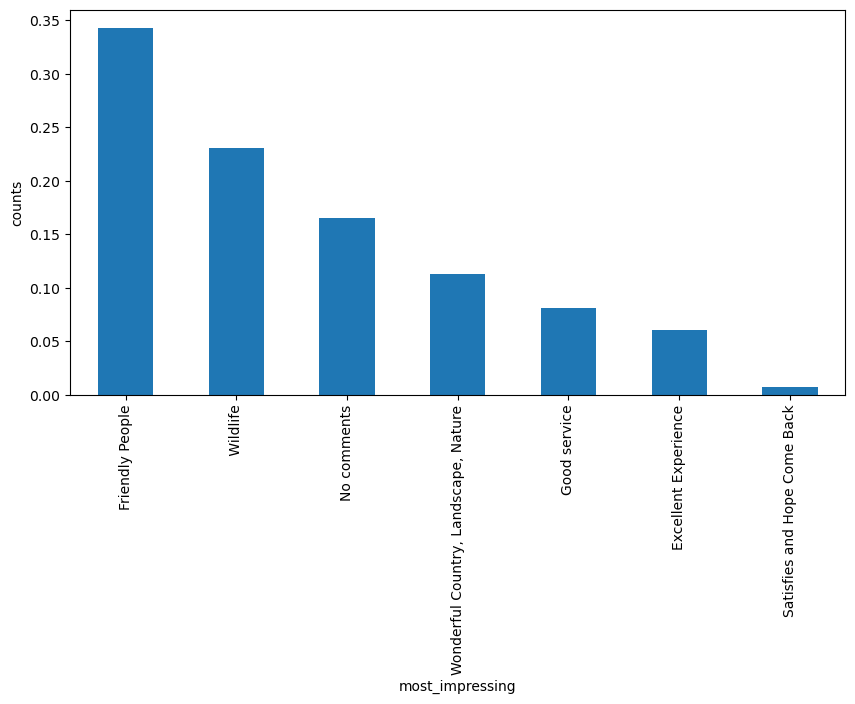

In [30]:
print(df['most_impressing'].value_counts())
plt.figure(figsize=(10,5))
df['most_impressing'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('most_impressing')

# Feature Engineering

In [31]:
df.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')

In [32]:
test.duplicated().any()
#no duplicates in the test set

False

In [33]:
df.duplicated().any()
#no duplicates

False

In [34]:
df.isnull().sum()

ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64

Scaling categorical columns

In [35]:
#Encoding Country column better-like african countries
#is_African = []
#african = ['SOUTH AFRICA', 'NIGERIA', 'RWANDA', 'MOZAMBIQUE', 'KENYA', 'ALGERIA', 'EGYPT','MALAWI', 
           ##'UGANDA', 'ZIMBABWE', 'ZAMBIA', 'CONGO', 'MAURITIUS', 'DRC', 'TUNISIA', 'ETHIOPIA','BURUNDI',
           #'GHANA', 'NIGER', 'COMORO', 'ANGOLA', 'SUDAN', 'NAMIBIA', 'LESOTHO', 'IVORY COAST', 'MADAGASCAR',
           #'DJIBOUT', 'MORROCO', 'BOTSWANA', 'LIBERIA', 'GUINEA', 'SOMALI']

#for country in df['country']:
  #if country in african:
   # is_African.append(True)
 # else:
   # is_African.append(False)

#df['is_african'] = is_African


In [36]:
#df['is_african']

In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Apply label encoding to each categorical column in the DataFrame
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column contains categorical variables
        df[column] = encoder.fit_transform(df[column])

print(df)

        ID  country  age_group  travel_with  total_female  total_male  \
0        0       89          2            2           1.0         1.0   
1        1       99          1            5           1.0         0.0   
2        2       99          1            0           0.0         1.0   
3        3       99          1            3           1.0         1.0   
4        4       13          0            5           1.0         0.0   
...    ...      ...        ...          ...           ...         ...   
4804  4804       95          2            0           0.0         1.0   
4805  4805      100          1            3           1.0         1.0   
4806  4806       64          0            5           1.0         0.0   
4807  4807       83          1            2           1.0         1.0   
4808  4808       99          1            3           1.0         1.0   

      purpose  main_activity  info_source  tour_arrangement  ...  \
0           1              7            0              

In [38]:
for column in test.columns:
    if test[column].dtype == 'object':  # Check if the column contains categorical variables
        test[column] = encoder.fit_transform(test[column])

In [39]:
#reducing skewness with log-transformation
#columns should be numerical
#Apply log transformation to selected columns
columns_to_transform = ['most_impressing','payment_mode', 'package_insurance','info_source','main_activity','total_male','total_female']

for column in columns_to_transform:
    df[column] = np.log1p(df[column])
for column in columns_to_transform:
    test[column] = np.log1p(test[column])

New Features

In [40]:
df['total_nights']=df['night_mainland']+ df['night_zanzibar']
df['total_people']=df['total_female']+ df['total_male']
df['total_transport']=df['package_transport_tz']+df['package_transport_int']
df['total_packages']=df['package_transport_int']+df['package_accomodation']+df['package_food']+df['package_transport_tz']+df['package_sightseeing']+df['package_guided_tour']+df['package_insurance']

In [41]:
test['total_nights']=test['night_mainland']+ test['night_zanzibar']
test['total_people']=test['total_female']+ test['total_male']
test['total_transport']=test['package_transport_tz']+test['package_transport_int']
test['total_packages']=test['package_transport_int']+test['package_accomodation']+test['package_food']+test['package_transport_tz']+test['package_sightseeing']+test['package_guided_tour']+test['package_insurance']

We can choose to drop columns with negative correlation

In [42]:
df.corr()['total_cost'].sort_values()

purpose                 -0.158429
most_impressing         -0.135130
country                 -0.062853
ID                      -0.060545
night_mainland           0.050208
main_activity            0.054737
travel_with              0.088674
payment_mode             0.100887
total_nights             0.127909
night_zanzibar           0.184906
total_male               0.202122
first_trip_tz            0.231757
info_source              0.235917
age_group                0.251077
package_insurance        0.272696
total_female             0.349010
package_guided_tour      0.373092
package_sightseeing      0.394056
total_people             0.421658
package_transport_int    0.428362
package_transport_tz     0.434377
package_food             0.435454
package_accomodation     0.463381
tour_arrangement         0.469240
total_transport          0.484958
total_packages           0.490388
total_cost               1.000000
Name: total_cost, dtype: float64

In [44]:
#letting scipy.stats identify the skewed columns
from scipy.stats import skew

# Identify skewed features
skewness = df.apply(lambda x: skew(x))
skewed_features = skewness[abs(skewness) > 0.5].index

# Apply a logarithmic transformation to skewed features
df[skewed_features] = np.log1p(df[skewed_features])


In [45]:
test[skewed_features] = np.log1p(test[skewed_features])

In [46]:
df1=df.drop(['ID'],axis=1)
test1=test.drop(['ID'],axis=1)

Lets check for nulls again

In [47]:
df1.isnull().sum()

country                  0
age_group                0
travel_with              0
total_female             3
total_male               5
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
total_nights             0
total_people             8
total_transport          0
total_packages           0
dtype: int64

In [48]:
df1=df1.fillna(0)
test1=test1.fillna(0)

In [49]:
df1.isnull().any().sum()

0

In [50]:
df1

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,total_nights,total_people,total_transport,total_packages
0,89,2,2,0.693147,0.693147,0.526589,0.753653,0.000000,0,0.000000,...,2.639057,0.000000,0.000000,0.000000,1.098612,13.421880,2.639057,1.386294,0.000000,0.000000
1,99,1,5,0.693147,0.000000,0.526589,0.625800,2.079442,0,0.000000,...,2.708050,1.124748,0.000000,0.526589,1.945910,14.983309,3.091042,0.693147,0.000000,0.000000
2,99,1,0,0.000000,0.693147,1.026672,0.625800,0.000000,0,0.000000,...,0.693147,1.248441,0.000000,0.000000,0.693147,15.013968,2.564949,0.693147,0.000000,0.000000
3,99,1,3,0.693147,0.693147,0.526589,0.753653,1.791759,1,0.000000,...,2.484907,0.000000,0.000000,0.526589,1.098612,15.868384,2.484907,1.386294,0.693147,5.000000
4,13,0,5,0.693147,0.000000,0.526589,0.753653,1.791759,0,0.000000,...,2.079442,0.959135,0.000000,0.526589,1.609438,14.320822,2.484907,0.693147,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4804,95,2,0,0.000000,0.693147,0.000000,0.706395,0.000000,0,0.000000,...,1.098612,0.000000,0.423036,0.000000,1.609438,15.013968,1.098612,0.693147,0.000000,0.000000
4805,100,1,3,0.693147,0.693147,0.526589,0.753653,1.791759,1,0.526589,...,2.484907,0.000000,0.000000,0.526589,1.098612,16.184901,2.484907,1.386294,1.098612,6.693147
4806,64,0,5,0.693147,0.000000,0.526589,0.753653,2.079442,0,0.000000,...,1.386294,1.124748,0.000000,0.526589,1.386294,14.624945,2.397895,0.693147,0.000000,0.000000
4807,83,1,2,0.693147,0.693147,0.000000,0.000000,1.791759,0,0.526589,...,1.791759,0.000000,0.423036,0.000000,1.098612,13.964147,1.791759,1.386294,0.693147,3.000000


In [51]:
#sns.pairplot(df)#to see if there is linear relation

In [52]:
df1.drop(columns = ['total_male', 'total_female'], inplace = True, axis = 1)
test1.drop(columns = ['total_male', 'total_female'], inplace = True, axis = 1)

# Model Building

We split the data into train set and the test set

In [53]:

X=df1.drop('total_cost',axis=1)
y=df1['total_cost']

In [54]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=102)

In [55]:
# Scaling the numeric values in the dataset

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_test_scaled = scaler.fit_transform(X_test)


In [56]:
X1 = pd.DataFrame(data=X_scaled, columns=X.columns)
test1=scaler.fit_transform(test1)

In [57]:
y

0       13.421880
1       14.983309
2       15.013968
3       15.868384
4       14.320822
          ...    
4804    15.013968
4805    16.184901
4806    14.624945
4807    13.964147
4808    16.400263
Name: total_cost, Length: 4809, dtype: float64

# Lgbm Regressor

In [58]:
#lets use lgbm regressor since this is a regression task
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define number of folds for cross-validation
num_folds = 5

# Initialize K-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize list to store the validation scores
scores = []

# Set the parameter grid for GridSearch
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [8, 12, 16],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6]
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X1, y)

# Get the best estimator/model from GridSearchCV
best_regressor = grid_search.best_estimator_



In [59]:
# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X1,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
  

    # Fit the best model obtained from GridSearch
    best_regressor.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = best_regressor.predict(X_test)

    # Calculate mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    lgbm_r2 = r2_score(y_test, y_pred)

    # Store the MSE score
    scores.append(mse)

# Print the mean and standard deviation of the MSE scores
print("Mean MSE:", np.mean(scores))
print("Standard Deviation of MSE:", np.std(scores))
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", lgbm_r2)# i like using r2 since it simple to understand model perforemance


Mean MSE: 1.22280586276482
Standard Deviation of MSE: 0.056932754485106825
Mean Squared Error (MSE): 1.289480520466241
Mean Absolute Error (MAE): 0.8538832672811411
R-squared (R2) Score: 0.5696273492290795


*for now lets settle with an r2 score of 0.56.*
*But we have to refresh our mind and come try new tricks untill the model gets r2 score of 0.7*

## Zindi Predictions

Importantly for me was to have the model perform good but lets proceed to making predictions with the test set

In [60]:
preds=best_regressor.predict(test1)
# Assuming y is your transformed target variable
transformed_preds = np.exp(preds)-1
subb=pd.DataFrame({
    'ID':test['ID'],
    'total_cost':transformed_preds
})


In [61]:
subb.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1601.0,8.000000e+02,4.623132e+02,0.00000,400.000000,800.000000,1.200000e+03,1.600000e+03
total_cost,1601.0,1.157295e+06,1.069844e+06,162460.11537,415789.668302,703137.101315,1.622181e+06,1.008197e+07


In [62]:
subb.to_csv('Sub_zindi.csv')

In [63]:
# I also dont get why they want us to use the ID column of sample submission, either way lets do it.
ss=pd.read_csv('SampleSubmission (5).csv')
ss

,ID,total_cost
0,tour_1,0
1,tour_100,0
2,tour_1001,0
3,tour_1006,0
4,tour_1009,0
...,...,...
1596,tour_988,0
1597,tour_990,0
1598,tour_992,0
1599,tour_996,0


In [64]:
newsub=pd.DataFrame({
    'ID':ss['ID'],
    'total_cost':transformed_preds
})
newsub.to_csv('tanzsub2.csv')

<h1 style="color:Orange"> THE END!</h1>